# Regressão Linear

Este caderno é uma tradução e adaptação do material do site d2l. Nele, iniciamos gerando um conjunto de dados artificial e, depois, exploramos os recursos do TensorFlow e Keras para implementar um modelo de regressão linear, testando nos dados criados. 

## Síntese de Dados para Regressão

Primeiramente, geramos um conjunto artificial de dados a partir de um modelo linear, para verificarmos o desempenho do nosso modelo regressor.


In [1]:
%matplotlib inline
import random
import tensorflow as tf
from d2l import tensorflow as d2l
import numpy as np

2024-04-28 17:32:13.951228: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 17:32:13.976381: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 17:32:13.976889: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 17:32:14.495379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Gerando o conjunto 

Vamos gerar 1000 examplos para um modelo com 2 variáveis independentes, com ruído aditivo normal. A matriz resultante $\mathbf{X}$
pertence a $\mathbb{R}^{1000 \times 2}$. 


$$\mathbf{y}= \mathbf{X} \mathbf{w} + b + \boldsymbol{\epsilon}.$$

Assumimo que $\boldsymbol{\epsilon}$ é normal com média $\mu= 0$ 
e desvio padrão $\sigma = 0.01$.


In [2]:
class SyntheticRegressionData(d2l.DataModule):  #@save
    """Synthetic data for linear regression."""
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,batch_size=32):
        super().__init__()
        self.save_hyperparameters()
        n = num_train + num_val
        self.X = tf.random.normal((n, w.shape[0]))
        noise = tf.random.normal((n, 1)) * noise
        self.y = tf.matmul(self.X, tf.reshape(w, (-1, 1))) + b + noise

A declaração ``#@save`` faz com que uma definição seja adicionada ao módulo d2l e possa ser chamada diretamente sem redefinição. A classe "hyperparameters", das quais nossos modelos são herdeiros, permite setar os hiperparâmetros do modelo (taxa de aprendizado, etc.). Ela permite, por assim dizer, estender o construtor do modelo em diferentes etapas, facilitando a leitura do código. 

Note que estabelecemos 1000 exemplos para treino e 1000 para avaliação do modelo. Discutiremos essas partições dos dados mais à frente. Definimos arbitrariamente  $\mathbf{w} = [2, -3.4]^\top$ e $b = 4.2$. Depois poderemos verificar se nosso modelo linear é capaz de "aprender" esses valores dos exemplos. 


In [3]:
data = SyntheticRegressionData(w=tf.constant([2, -3.4]), b=4.2)

**Cada linha em `features` é um vetor em  $\mathbb{R}^2$ e cada linha em `labels` é um escalar.**


In [4]:
print('features:', data.X[0],'\nlabel:', data.y[0])

features: tf.Tensor([-0.84678555  0.1024878 ], shape=(2,), dtype=float32) 
label: tf.Tensor([2.1528714], shape=(1,), dtype=float32)


### Lendo o Conjunto de Dados

Aqui usamos métodos pré-definidos no d2l para leitura dos dados para treinamento e teste. Estes métodos recebem os dados gerados (exemplos e alvo), um tamanho de "batch" e então quebram o arquivo em minibatches. Note que há opção para dizer se estamos em treinamento ou em validação (falaremos mais sobre isso adiante). No treinamento, é interessante ler os dados em ordem aleatória. No último, para efeitos de depuração, é bom usar uma ordem pré-definida. 

O método ``add_to_class`` permite que um método seja incorporado a uma classe (até mesmo para objetos já criados), de novo para permitir uma maior legibilidade do código. 

In [19]:
@d2l.add_to_class(d2l.DataModule)  #@save
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
    tensors = tuple(a[indices] for a in tensors)
    shuffle_buffer = tensors[0].shape[0] if train else 1
    return tf.data.Dataset.from_tensor_slices(tensors).shuffle(
        buffer_size=shuffle_buffer).batch(self.batch_size)

In [20]:
@d2l.add_to_class(SyntheticRegressionData)  #@save
def get_dataloader(self, train):
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader((self.X, self.y), train, i)

Podemos agora invocar o método `train_dataloader`, previamente implementado no módulo d2l e que invoca o método recém-adicionado `get_dataloader` com `train=1`. Como vemos a seguir, podemos iterar por cada minibatch com o tamanho esperado em `batch_size`.

In [21]:
X, y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: (32, 2) 
y shape: (32, 1)


## Implementação da Regressão Linear

Agora, executamos a implementação de um modelo de regressão linear usando APIs pré-definidas.

### Definindo o modelo 

A bilioteca Keras tem várias funções que nos auxiliam na definição de redes neurais. Para este modelo linear, estamos falando de uma rede neural de uma camada totalmente conectada, no caso conectando $d$ entradas a um único neurônio. Isto é obtido pela classe ``tf.keras.layers.Dense`` 

Notar que não precisamos definir o tamanho da camada (no caso, quantas entradas se conectam ao neurônio). Isto será inferido quando passarmos dados para a rede. 

In [22]:
class LinearRegression(d2l.Module):  #@save
    """The linear regression model implemented with high-level APIs."""
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        initializer = tf.initializers.RandomNormal(stddev=0.01)
        self.net = tf.keras.layers.Dense(1, kernel_initializer=initializer)

No método `forward` apenas invocamos a rede para computar os dados e obter a estimativa. Estamos na verdade "chamando" a instância da classe Dense como se fosse uma função, graças ao recurso do Python que permite isso via implementação na classe do método especial `__call__`.


In [23]:
@d2l.add_to_class(LinearRegression)  #@save
def forward(self, X):
    return self.net(X)

### Definindo a Função de Custo

A classe `MeanSquaredError` computa o erro médio quadrático.

In [24]:
@d2l.add_to_class(LinearRegression)  #@save
def loss(self, y_hat, y):
    fn = tf.keras.losses.MeanSquaredError()
    return fn(y, y_hat)

### Definindo o Algoritmo de Otimização

A Descida por Gradiente Estocástico (SGD - Stochastic Gradient Descent) está implementada em Keras, já com a opção de minibatches. 

In [25]:
@d2l.add_to_class(LinearRegression)  #@save
def configure_optimizers(self):
    return tf.keras.optimizers.SGD(self.lr)

### Treinamento

Mais uma vez, com o uso das classses pré-definidas, em particular a classe ``Trainer`` e o método ``fit``, o algoritmo de treinamento pode ser definido de uma forma simples. 

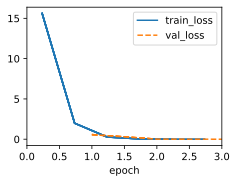

In [26]:
model = LinearRegression(lr=0.03)
data = d2l.SyntheticRegressionData(w=tf.constant([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

Nós geramos esses dados a partir de uma verdadeira relação linear $y=2x_{1}-3.4x_{2}+4.2$, com ruído adicionado. Abaixo, comparamos esses valores verdadeiros com os "aprendidos" pelo sistema. Observe mais um método definido (`get_w_b`, para acessar os parâmetros $w$ e $b$ do modelo). 


In [27]:
@d2l.add_to_class(LinearRegression)  #@save
def get_w_b(self):
    return (self.get_weights()[0], self.get_weights()[1])

w, b = model.get_w_b()
print((w,b))
print(f'error in estimating w: {data.w - w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - b}')

(array([[ 1.9937489],
       [-3.3908026]], dtype=float32), array([4.1896467], dtype=float32))
error in estimating w: [ 0.0062511  -0.00919747]
error in estimating b: [0.01035309]
